In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# -------------------- 1. Load Data with Random Sampling --------------------
DATA_PATH = "../data/icwsm-2024-forecasting-data-anon.json"
SAMPLE_FRACTION = 0.1  # 10% of total data
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
print(f"📂 Loading {SAMPLE_FRACTION*100:.0f}% random sample from {DATA_PATH}...")

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"📊 Total records in full dataset: {len(raw_data):,}")
print(f"🎯 Random sampling: {SAMPLE_FRACTION*100:.0f}%")

# Random sampling of keys
all_keys = list(raw_data.keys())
sampled_keys = random.sample(all_keys, int(len(all_keys) * SAMPLE_FRACTION))

records = []
for key in tqdm(sampled_keys, desc="Loading records"):
    value = raw_data[key]
    records.append({
        'user_id': value['user_id_anonymized'],
        'timestamp': pd.to_datetime(value['created_at']),
        'sources': value['news sources'],
        'stances': value['partisan stance']
    })

df = pd.DataFrame(records)
print(f"\n✅ Total records in sample: {len(df):,}")
print(f"✅ Unique users: {df['user_id'].nunique():,}")
print(f"✅ Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"✅ Avg engagements per user: {df.groupby('user_id').size().mean():.2f}")

df.head()

📂 Loading 10% random sample from ../data/icwsm-2024-forecasting-data-anon.json...
📊 Total records in full dataset: 5,637,781
🎯 Random sampling: 10%


Loading records: 100%|██████████| 563778/563778 [07:25<00:00, 1265.48it/s]



✅ Total records in sample: 563,778
✅ Unique users: 5,975
✅ Date range: 2009-03-02 to 2021-09-19
✅ Avg engagements per user: 94.36


,user_id,timestamp,sources,stances
0,81ebd099-14eb-4b22-a226-f57e091ef323,2021-07-30 17:36:08+00:00,[CNN Online News],[-2.0]
1,10f386c5-ae63-4771-ad86-55b2f18a8d32,2017-03-24 21:04:53+00:00,[Mother Jones],[-2.0]
2,221d67d3-edc7-478e-9e47-afc7f683e1bf,2014-09-03 12:45:30+00:00,[Arkansas DemocratGazette],[-2.0]
3,02e45eb2-9472-4631-9881-4a21505e0f90,2019-04-21 08:31:01+00:00,[The Daily Caller],[2.0]
4,4b436900-d4a5-42e0-815f-cc9c536d78f5,2018-12-20 13:17:05+00:00,[ABC News Online],[-1.0]


In [5]:
# -------------------- 2. Helper Columns --------------------
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.to_period('Q')
df['year_quarter'] = df['timestamp'].dt.to_period('Q').astype(str)

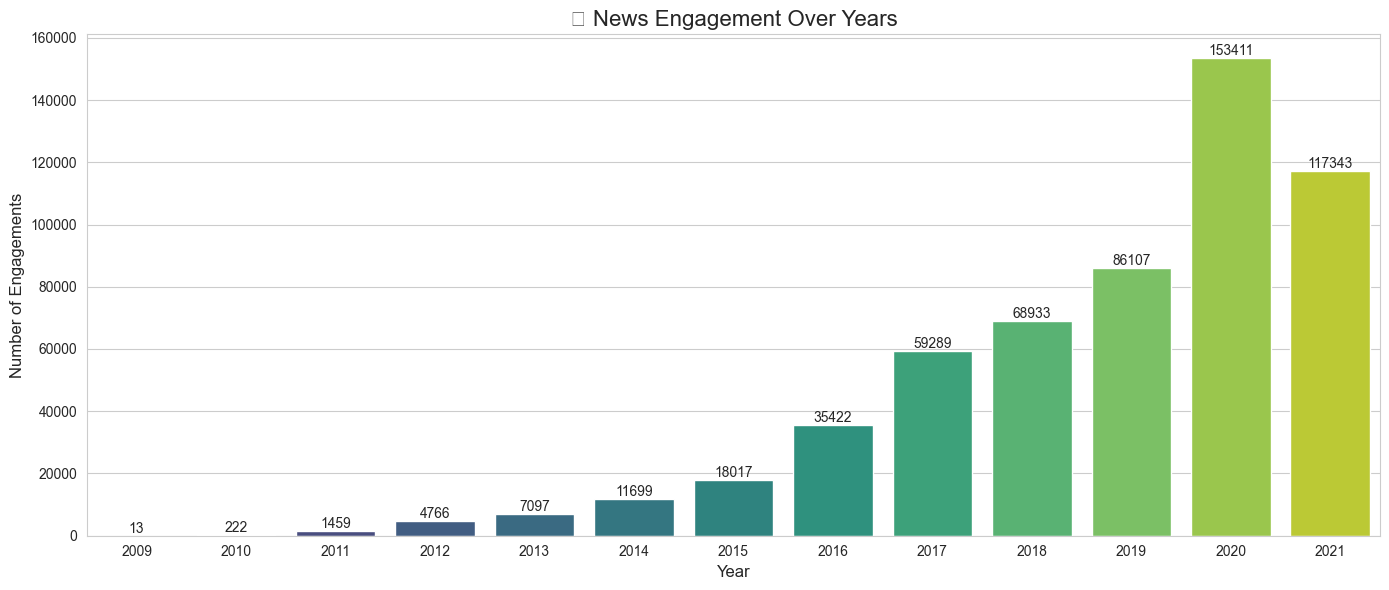

In [6]:
# -------------------- 3. Plot 1: Temporal Distribution --------------------
yearly_counts = df['year'].value_counts().sort_index()
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')
plt.title('📅 News Engagement Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Engagements', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


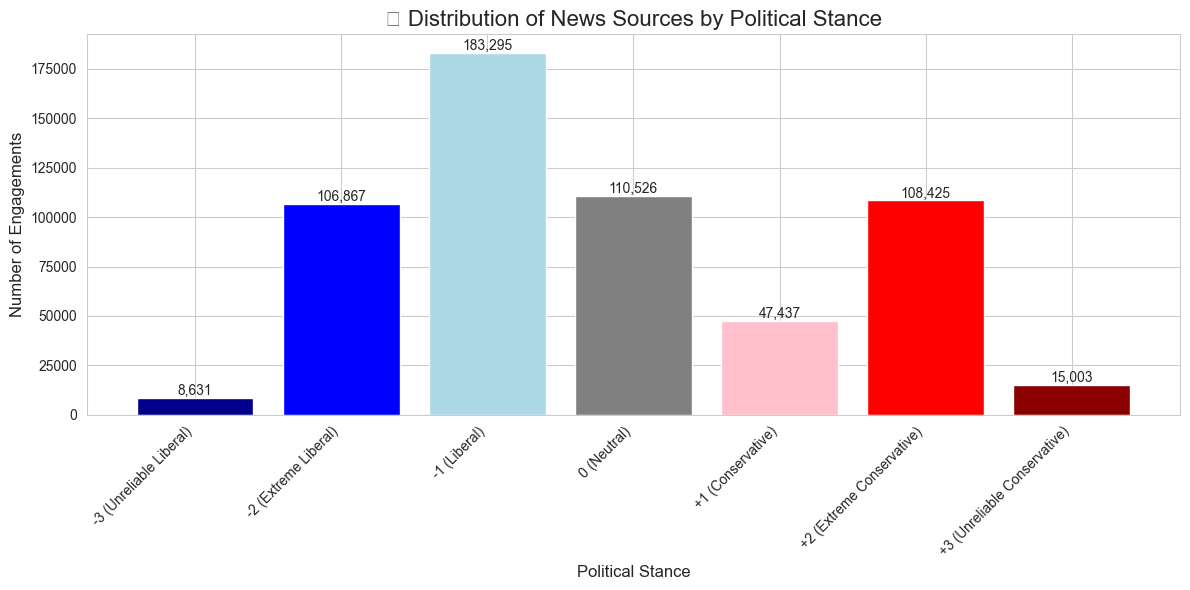

In [7]:
# -------------------- 4. Plot 2: Distribution of Political Stances --------------------
stance_counter = Counter()
for stances in df['stances']:
    stance_counter.update(stances)

stance_df = pd.DataFrame(stance_counter.items(), columns=['stance', 'count'])
stance_df = stance_df.sort_values('stance')

stance_labels = ['-3 (Unreliable Liberal)', '-2 (Extreme Liberal)', '-1 (Liberal)',
                 '0 (Neutral)', '+1 (Conservative)', '+2 (Extreme Conservative)', 
                 '+3 (Unreliable Conservative)']
stance_df['label'] = stance_df['stance'].astype(int).map({-3: stance_labels[0], -2: stance_labels[1],
                                                          -1: stance_labels[2], 0: stance_labels[3],
                                                          1: stance_labels[4], 2: stance_labels[5],
                                                          3: stance_labels[6]})

plt.figure(figsize=(12, 6))
bars = plt.bar(stance_df['label'], stance_df['count'], 
               color=['darkblue', 'blue', 'lightblue', 'gray', 'pink', 'red', 'darkred'])
plt.xticks(rotation=45, ha='right')
plt.title('📊 Distribution of News Sources by Political Stance', fontsize=16)
plt.xlabel('Political Stance', fontsize=12)
plt.ylabel('Number of Engagements', fontsize=12)
for bar, count in zip(bars, stance_df['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

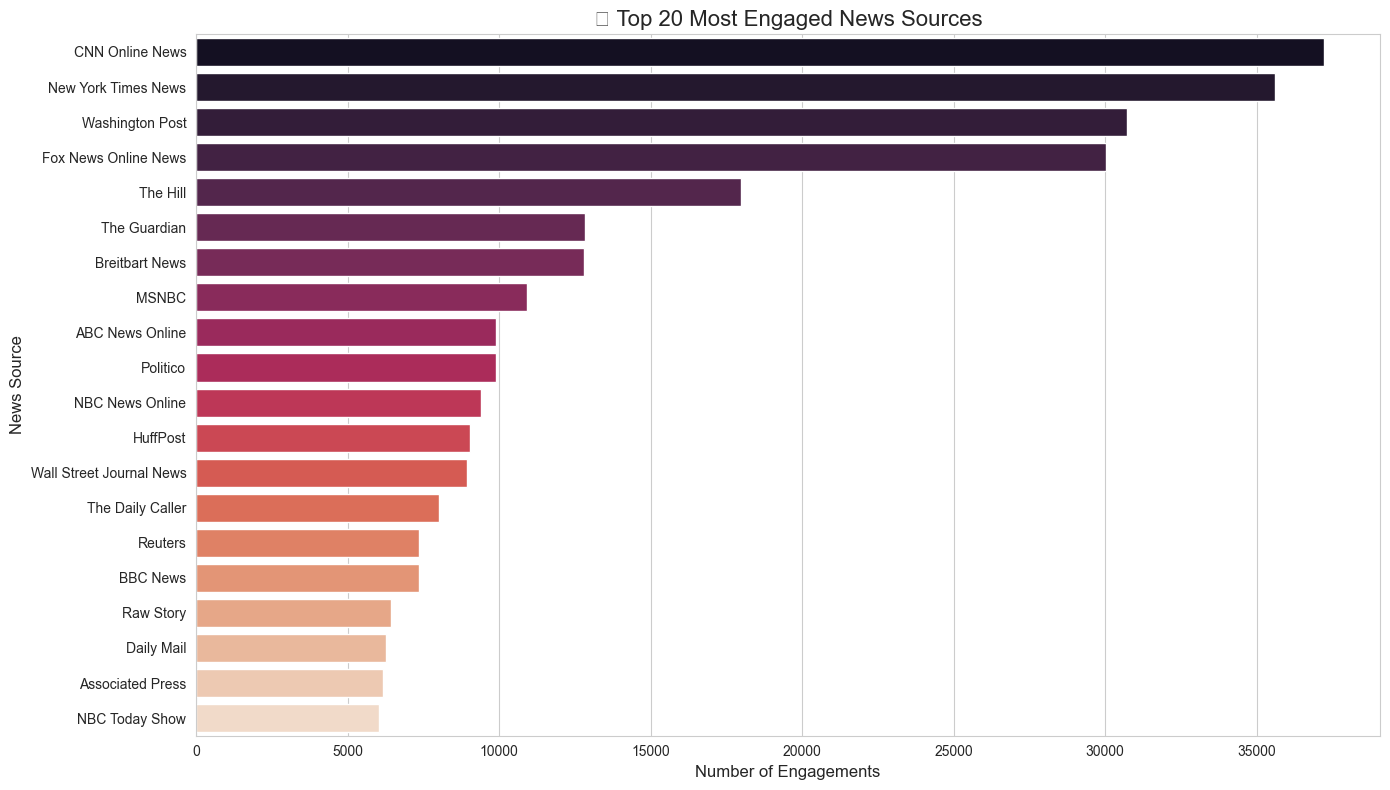

In [8]:
# -------------------- 5. Plot 3: Top News Sources --------------------
source_counter = Counter()
for sources in df['sources']:
    source_counter.update(sources)

top_sources = source_counter.most_common(20)
top_sources_df = pd.DataFrame(top_sources, columns=['source', 'count'])

plt.figure(figsize=(14, 8))
sns.barplot(data=top_sources_df, y='source', x='count', palette='rocket')
plt.title('🏆 Top 20 Most Engaged News Sources', fontsize=16)
plt.xlabel('Number of Engagements', fontsize=12)
plt.ylabel('News Source', fontsize=12)
plt.tight_layout()
plt.show()


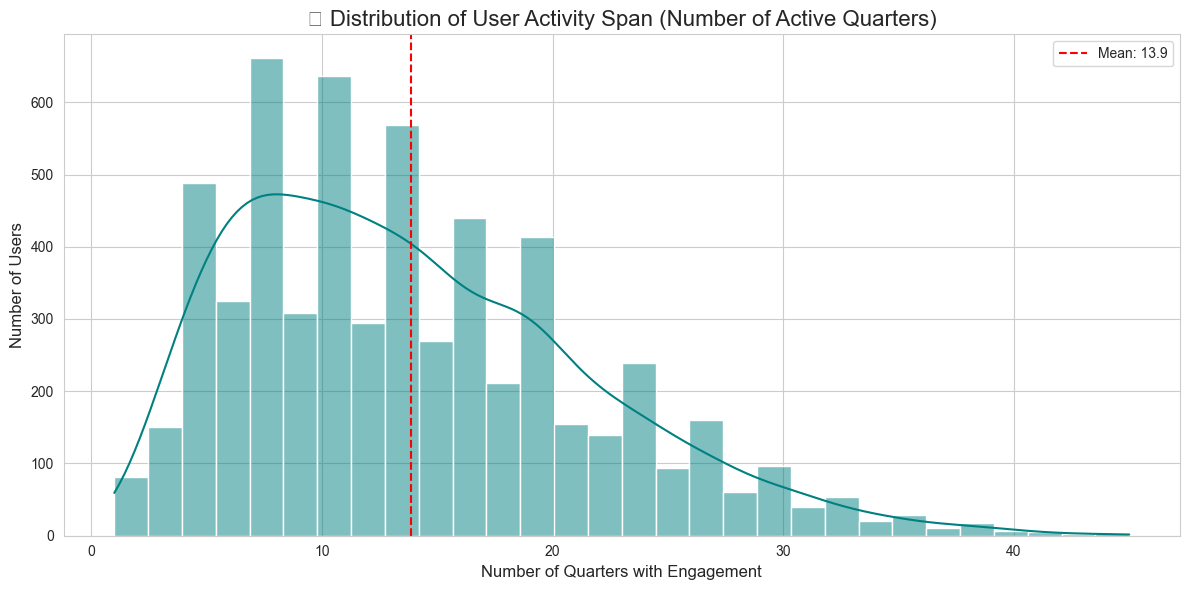

Sequence Length Statistics:
  Min: 1
  Max: 45
  Mean: 13.88
  Median: 13.0


In [9]:
# -------------------- 6. Plot 4: User Sequence Length Distribution --------------------
# Count number of active quarters per user
user_quarter_counts = df.groupby('user_id')['quarter'].nunique()

plt.figure(figsize=(12, 6))
sns.histplot(user_quarter_counts, bins=30, kde=True, color='teal')
plt.title('📈 Distribution of User Activity Span (Number of Active Quarters)', fontsize=16)
plt.xlabel('Number of Quarters with Engagement', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.axvline(user_quarter_counts.mean(), color='red', linestyle='--', 
            label=f'Mean: {user_quarter_counts.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Sequence Length Statistics:")
print(f"  Min: {user_quarter_counts.min()}")
print(f"  Max: {user_quarter_counts.max()}")
print(f"  Mean: {user_quarter_counts.mean():.2f}")
print(f"  Median: {user_quarter_counts.median()}")


Building user-stance matrix: 100%|██████████| 5975/5975 [00:02<00:00, 2933.73it/s]


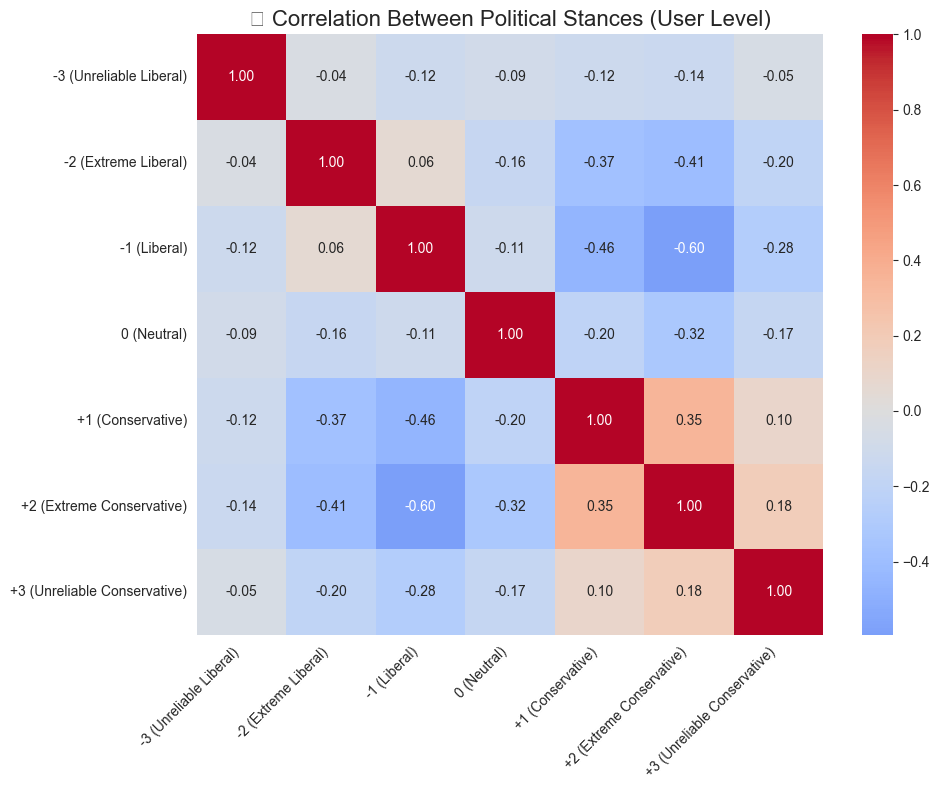

In [10]:
# -------------------- 7. Plot 5: Correlation Between Political Stances --------------------
# Build user-stance engagement matrix
user_stance_matrix = []

for user_id, group in tqdm(df.groupby('user_id'), desc="Building user-stance matrix"):
    stance_counts = np.zeros(7)
    for stances in group['stances']:
        for stance in stances:
            idx = int(stance) + 3
            if 0 <= idx < 7:
                stance_counts[idx] += 1
    # Normalize by user's total engagements
    if stance_counts.sum() > 0:
        stance_counts = stance_counts / stance_counts.sum()
    user_stance_matrix.append(stance_counts)

user_stance_matrix = np.array(user_stance_matrix)
correlation_matrix = np.corrcoef(user_stance_matrix.T)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=stance_labels, yticklabels=stance_labels)
plt.title('🔗 Correlation Between Political Stances (User Level)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

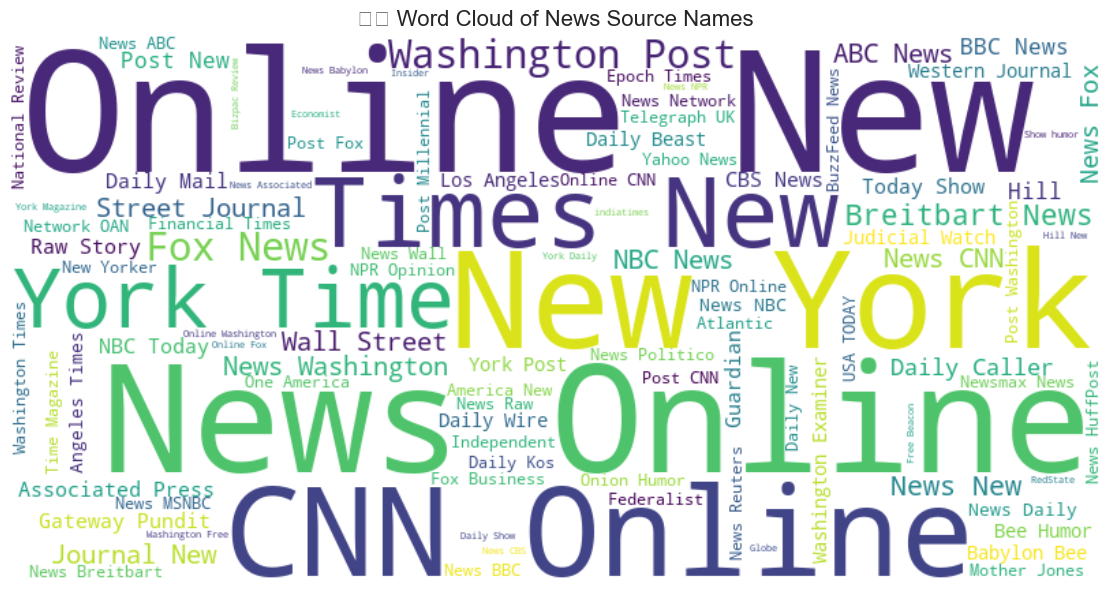

In [11]:
# -------------------- 8. Plot 6 (Optional): Word Cloud of News Sources --------------------
# Since tweet text is not available, we use news source names as text
all_sources_text = ' '.join([' '.join(sources) for sources in df['sources']])

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=100).generate(all_sources_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Word Cloud of News Source Names', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
print("✅ Exploratory Data Analysis completed successfully.")

✅ Exploratory Data Analysis completed successfully.
